In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [59]:
device

device(type='cpu')

In [60]:
#mention the ticker for the company and the date to start the fetching of the data from
ticker = 'AAPL'
df = yf.download(ticker, '2020-01-01')

[*********************100%***********************]  1 of 1 completed


In [61]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.620842,72.681289,71.373218,71.627092,135480400
2020-01-03,71.914810,72.676439,71.689950,71.847110,146322800
2020-01-06,72.487839,72.526526,70.783241,71.034702,118387200
2020-01-07,72.146942,72.753823,71.926915,72.497529,108872000
2020-01-08,73.307503,73.609737,71.849525,71.849525,132079200
...,...,...,...,...,...
2025-05-30,200.850006,201.960007,196.779999,199.369995,70819900
2025-06-02,201.699997,202.130005,200.119995,200.279999,35423300


<Axes: xlabel='Date'>

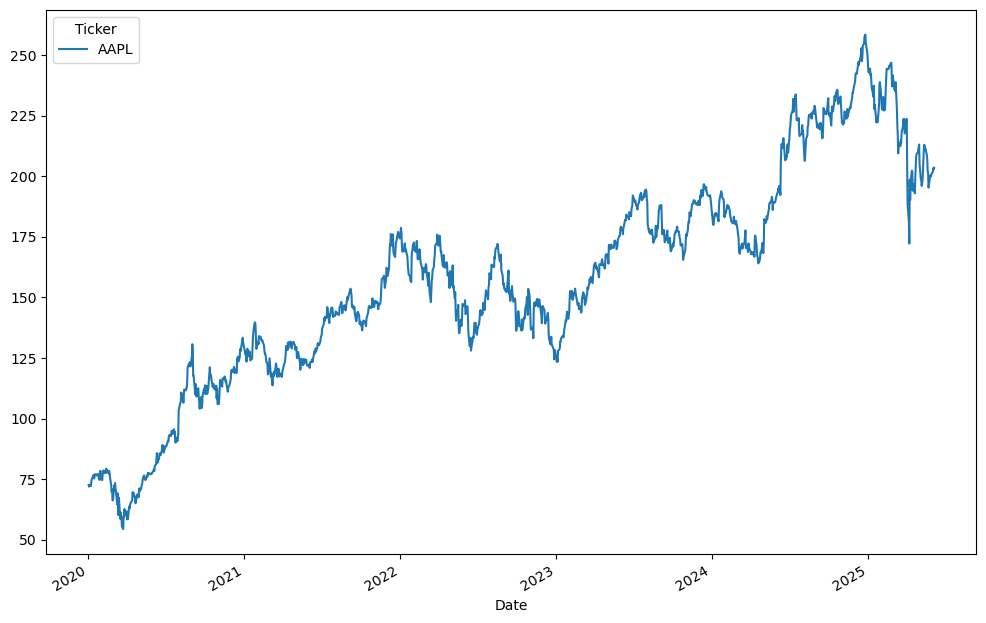

In [10]:
df.Close.plot(figsize=(12,8))

In [62]:
scaler = StandardScaler()

In [63]:
df['Close'] = scaler.fit_transform(df['Close'])

In [76]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,-1.904931,72.681289,71.373218,71.627092,135480400
2020-01-03,-1.920839,72.676439,71.689950,71.847110,146322800
2020-01-06,-1.907927,72.526526,70.783241,71.034702,118387200
2020-01-07,-1.915608,72.753823,71.926915,72.497529,108872000
2020-01-08,-1.889459,73.609737,71.849525,71.849525,132079200
...,...,...,...,...,...
2025-05-30,0.984298,201.960007,196.779999,199.369995,70819900
2025-06-02,1.003450,202.130005,200.119995,200.279999,35423300


In [77]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

train_size = int(0.8* len(data))
#What actually we did here : WE created a overlapping sliding windows of our data in the close cloumn
# where every window is of len of seq_length consecutive values. We subtract the seq_length from the len of
# the  dataframe is to make sure we dont go out of bounds when slicing
#This ensures that you don’t go out of bounds when slicing.

#If your DataFrame has 1000 rows and seq_length = 30, you’ll generate 1000 - 30 = 970 sequences.

#Loop: for i in range(...):

#Iterates over each possible starting index i for a sequence of length 30.

#df.close[i:i+seq_length]:

#This slices out a sequence of 30 consecutive closing prices, starting at index i.

#data.append(...):

#Each 30-step sequence is appended to the list data.
# above details generated from chatgpt

In [14]:
data.shape

(1334, 30, 1)

In [78]:

# We want the first 80% of the data as train and we are predicting the sequential price, 
# not the regular training testing split like in scikitlearn because it takes random 80 
# percent of the data we dont want that
X_train = torch.from_numpy(data[:train_size, :-1,:]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1,:]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1,:]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1,:]).type(torch.Tensor).to(device)

In [40]:
y_train

tensor([[-1.7671],
        [-1.7667],
        [-1.7992],
        ...,
        [ 0.5439],
        [ 0.5515],
        [ 0.5925]])

In [79]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn,cn) = self.lstm(x,(h0.detach(),c0.detach()))
        out = self.fc(out[:,-1,:])
        return out

In [80]:
model = PredictionModel(input_dim=1,hidden_dim=32,num_layers=2,output_dim=1).to(device)

In [81]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [82]:
epochs = 200

for i in range(epochs):
    y_train_pred = model(X_train)
    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(i,loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

0 tensor(0.5710, grad_fn=<MseLossBackward0>)
25 tensor(0.0111, grad_fn=<MseLossBackward0>)
50 tensor(0.0062, grad_fn=<MseLossBackward0>)
75 tensor(0.0054, grad_fn=<MseLossBackward0>)
100 tensor(0.0049, grad_fn=<MseLossBackward0>)
125 tensor(0.0046, grad_fn=<MseLossBackward0>)
150 tensor(0.0043, grad_fn=<MseLossBackward0>)
175 tensor(0.0040, grad_fn=<MseLossBackward0>)


In [83]:

model.eval()



y_test_pred = model(X_test)

y_train_pred_np = y_train_pred.detach().cpu().numpy()
y_train_np = y_train.detach().cpu().numpy()
y_test_pred_np = y_test_pred.detach().cpu().numpy()
y_test_np = y_test.detach().cpu().numpy()

y_train_pred = scaler.inverse_transform(y_train_pred_np)
y_train = scaler.inverse_transform(y_train_np)
y_test_pred = scaler.inverse_transform(y_test_pred_np)
y_test = scaler.inverse_transform(y_test_np)


In [85]:
train_rmse = root_mean_squared_error(y_train[:,0], y_train_pred[:,0])
test_rmse = root_mean_squared_error(y_test[:,0],y_test_pred[:,0])

In [86]:
train_rmse

2.710726

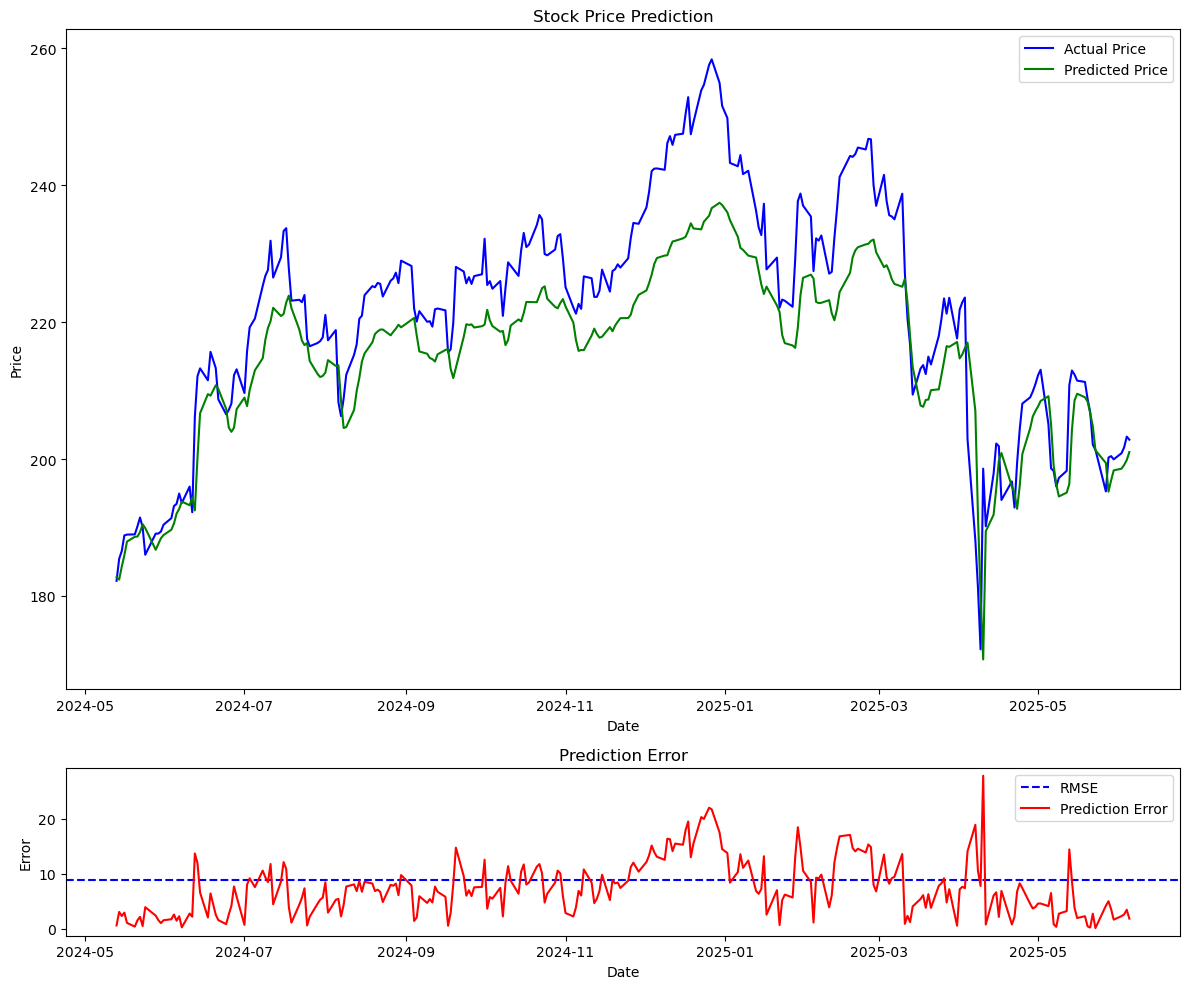

In [90]:
fig = plt.figure(figsize=(12,10))
gs = fig.add_gridspec(4,1)

ax1 = fig.add_subplot(gs[:3,0])
ax1.plot(df.iloc[-len(y_test):].index, y_test,color='blue',label = 'Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred,color='green',label = 'Predicted Price')
ax1.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3,0])
ax2.axhline(test_rmse, color = 'blue', linestyle='--', label='RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label = 'Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')
plt.tight_layout()
plt.show()